# Modelo de predicción de noticias falsas y Modelo de Análisis de Estilo y Lenguaje
## Análisis y limpieza de datos

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from wordcloud import WordCloud, ImageColorGenerator
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
import re

nltk.download('stopwords')
nltk.download('wordnet')

df = pd.read_csv('fake_news_dataset.csv')

df.head()


[nltk_data] Downloading package stopwords to /home/pelli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/pelli/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,title,text,date,source,author,category,label
0,Foreign Democrat final.,more tax development both store agreement lawy...,2023-03-10,NY Times,Paula George,Politics,real
1,To offer down resource great point.,probably guess western behind likely next inve...,2022-05-25,Fox News,Joseph Hill,Politics,fake
2,Himself church myself carry.,them identify forward present success risk sev...,2022-09-01,CNN,Julia Robinson,Business,fake
3,You unit its should.,phone which item yard Republican safe where po...,2023-02-07,Reuters,Mr. David Foster DDS,Science,fake
4,Billion believe employee summer how.,wonder myself fact difficult course forget exa...,2023-04-03,CNN,Austin Walker,Technology,fake


In [38]:
print(f"El df orignialmente tenia {df.shape[0]} columnas.")

#Elimina los valores nulos
df_no_na = df.dropna()
df_no_na = df_no_na.drop_duplicates()
df_no_na.shape[0]
print(f"El dataframe sin duplicados ni na tiene {df_no_na.shape[0]} columnas.")

El df orignialmente tenia 20000 columnas.
El dataframe sin duplicados ni na tiene 18045 columnas.


Al ver que hay valores nulos, primero borramos las filas con estos. Luego comprobamos la calidad de los datos en sí del dataset escogido, para ello, revisamos que no haya datos nulos o noticias repetidas. Como se puede observar por el resultado, el dataframe no contenía nulos ni noticias duplicadas y por tanto podemos contar con todas las noticias del dataset.

In [56]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

cont = df['label'].value_counts()

print(cont)

label
fake    9553
real    9447
Name: count, dtype: int64


También comprobamos que el número de noticias sea parejo para que esto no pueda a afectar en un sesgo hacia uno de los tipos a la hora de clasificar noticias en nuestro modelo.

In [40]:
# Vemos las distintas columnas del dataframe para ver si alguna de estas contiene información que no sea relevante
df.columns

Index(['title', 'text', 'date', 'source', 'author', 'category', 'label'], dtype='object')

Tras ver las distintas columnas del dataframe, podemos ver como todas las columnas que contienen parecen poder ser interesantes a excepción de algunas:
 - source: Esta nos dice la fuente de la que proviene el artículo, puede sernos de ayuda, pero también podría ser que sesgue mucho por la fuente de la que proviene y no el autor del artículo o que las fuentes del dataframe no sean suficientes para todas las fuentes con las que nos podríamos encontrar fuera del dataset.
 - author: Al igual que el dataset, los autores pueden ser demasiado variados y esto ser un problema, solo que en lo que respecta a esta columna la variedad es mayor, llegando a hacernos pensar que esta no puede ser de ninguna utilidad y por tanto la eliminaremos.
 - date: Puede que en esta no se encuentre ninguna información relevante y por tanto pueda ser eliminada, sin embargo, puede que esta tenga información relevante como que cerca de fechas de elecciones politicas etc se frecuente más las fake news.

 Con esto en mente, eliminaremos la columna de autor y revisaremos si las columnas de fuente o fecha nos pueden ser útiles.


In [41]:
# Eliminamos las columnas que consideramos innecesarias del dataframe
df.drop(columns=['author'], inplace=True)

Tras eliminar las columnas que consideramos irrelevants, vamos a realizar el encoding de aquellas columnas que poseen un valor String pero este valor pertenece a una categoria. Y que por tanto pueden ser codificados de manera numérica haciendo uso de label encoding o one-hot encoding. Se va a aplicar en las siguientes columnas:
- category: para este dato se obtará por one-hot encoding ya que se dispone de varias categorías y no hay diferencias entre ellas, por tanto el uso de label encoding podría hacer pensar a nuestro modelo que si que existe distintas diferencias entre las categorias.
- label: se trata del campo y como solo puede tomar dos valores, se obtará por label encoding para no sobrecargar de columnas el dataset.

In [42]:
df_encoded = pd.get_dummies(df, columns=['category'], dtype=int)
df_encoded['label'] = df_encoded['label'].map({'fake': 0, 'real': 1})

df_encoded.head()

,title,text,date,source,label,category_Business,category_Entertainment,category_Health,category_Politics,category_Science,category_Sports,category_Technology
0,Foreign Democrat final.,more tax development both store agreement lawy...,2023-03-10,NY Times,1,0,0,0,1,0,0,0
1,To offer down resource great point.,probably guess western behind likely next inve...,2022-05-25,Fox News,0,0,0,0,1,0,0,0
2,Himself church myself carry.,them identify forward present success risk sev...,2022-09-01,CNN,0,1,0,0,0,0,0,0
3,You unit its should.,phone which item yard Republican safe where po...,2023-02-07,Reuters,0,0,0,0,0,1,0,0
4,Billion believe employee summer how.,wonder myself fact difficult course forget exa...,2023-04-03,CNN,0,0,0,0,0,0,0,1


Procedemos a hacer una matriz de correlación con aquellos valores numéricos

In [43]:
#df_numeric = df_encoded.select_dtypes(include=['int64', 'float64'])  # Selecciona solo columnas numérica

#df_numeric.head()

#correlation_matrix = df_numeric.corr(method='pearson')  # Calcula la matriz de correlación

#plt.figure(figsize=(12, 8))  # Ajusta el tamaño del gráfico
#sns.heatmap(
 #   correlation_matrix,
 #   annot=True,      # Muestra los valores de correlación
 #   fmt=".2f",      # Formato de 2 decimales
 #   cmap="coolwarm", # Mapa de colores (rojo-negro-azul)
 #   vmin=-1,        # Rango mínimo de correlación
 #   vmax=1,         # Rango máximo de correlación
 #   linewidths=0.5,
#)
#plt.title("Matriz de Correlación (Columnas Numéricas)")
#plt.show()

In [44]:
# Calcular el número de palabras por noticia (split por espacios)
df_encoded['word_count'] = df_encoded['text'].apply(lambda x: len(x.split()))

df_encoded['char_count'] = df_encoded['text'].str.len()

print(df_encoded[['text', 'label', 'word_count', 'char_count']])

                                                    text  label  word_count  \
0      more tax development both store agreement lawy...      1         216   
1      probably guess western behind likely next inve...      0         238   
2      them identify forward present success risk sev...      0         222   
3      phone which item yard Republican safe where po...      0         247   
4      wonder myself fact difficult course forget exa...      0         215   
...                                                  ...    ...         ...   
19995  hit and television I change very our happy doo...      0         292   
19996  fear most meet rock even sea value design stan...      1         258   
19997  activity loss very provide eye west create wha...      1         239   
19998  term point general common training watch respo...      0         245   
19999  remain pressure glass me six senior though nor...      0         222   

       char_count  
0            1434  
1          

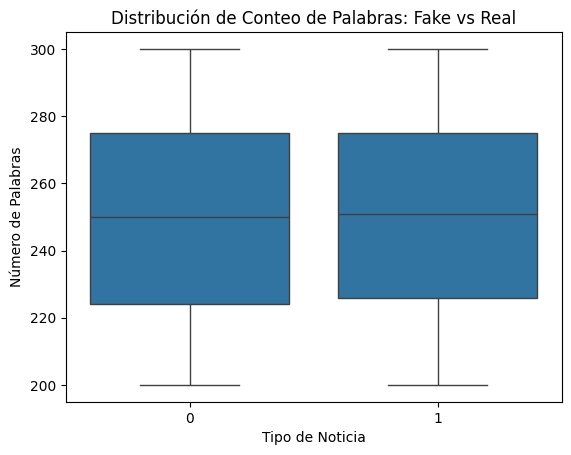

In [45]:
sns.boxplot(x='label', y='word_count', data=df_encoded)
plt.title("Distribución de Conteo de Palabras: Fake vs Real")
plt.xlabel("Tipo de Noticia")
plt.ylabel("Número de Palabras")
plt.show()

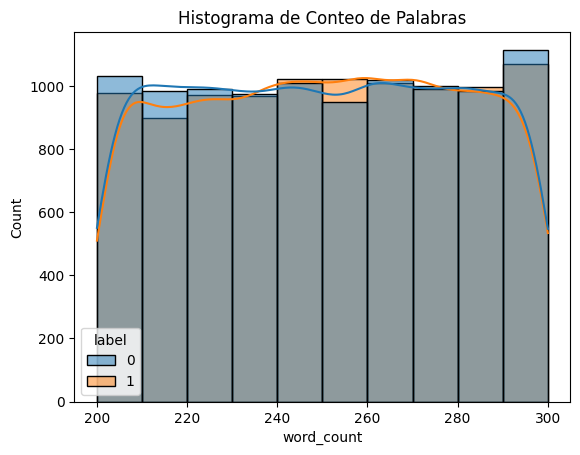

In [46]:
sns.histplot(data=df_encoded, x='word_count', hue='label', kde=True, bins=10)
plt.title("Histograma de Conteo de Palabras")
plt.show()

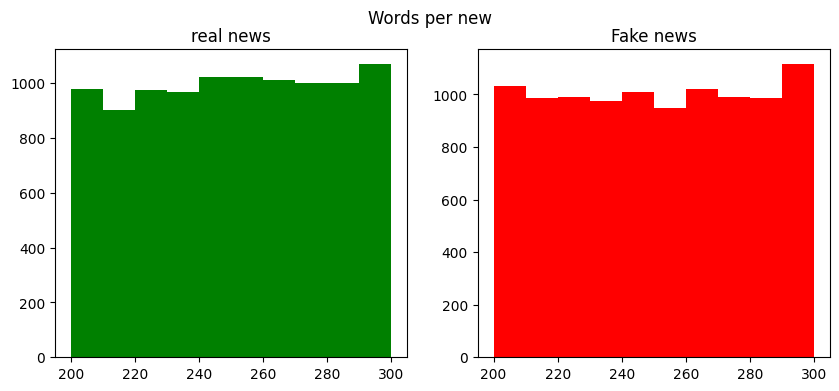

In [47]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_encoded[df_encoded['label']==1]['word_count']
ax1.hist(train_words,color='green')
ax1.set_title('real news')
train_words=df_encoded[df_encoded['label']==0]['word_count']
ax2.hist(train_words,color='red')
ax2.set_title('Fake news')
fig.suptitle('Words per new')
plt.show()

Primero vemos si existe una gran diferencia entre el conteo de las palabras de las noticias fake y de las noticias reales, podemos ver como las noticias reales tienden a tener más palabras que las Fake. Pero no por mucho, la diferencia no es muy grande ni relevante, a continuación haremos lo mismo con los caracteres.

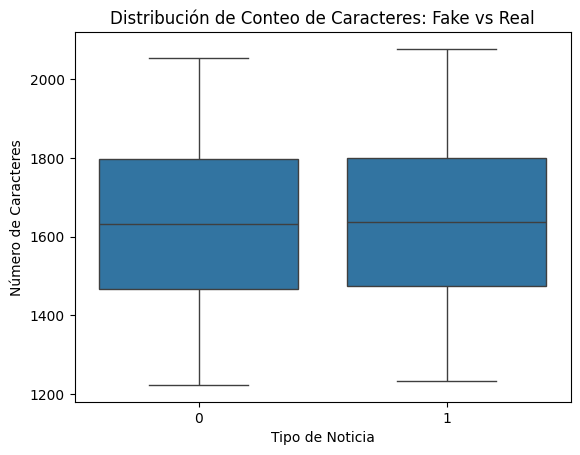

In [48]:
sns.boxplot(x='label', y='char_count', data=df_encoded)
plt.title("Distribución de Conteo de Caracteres: Fake vs Real")
plt.xlabel("Tipo de Noticia")
plt.ylabel("Número de Caracteres")
plt.show()

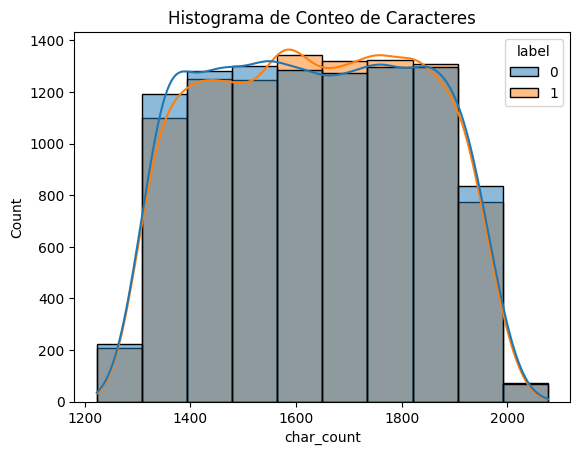

In [49]:
sns.histplot(data=df_encoded, x='char_count', hue='label', kde=True, bins=10)
plt.title("Histograma de Conteo de Caracteres")
plt.show()

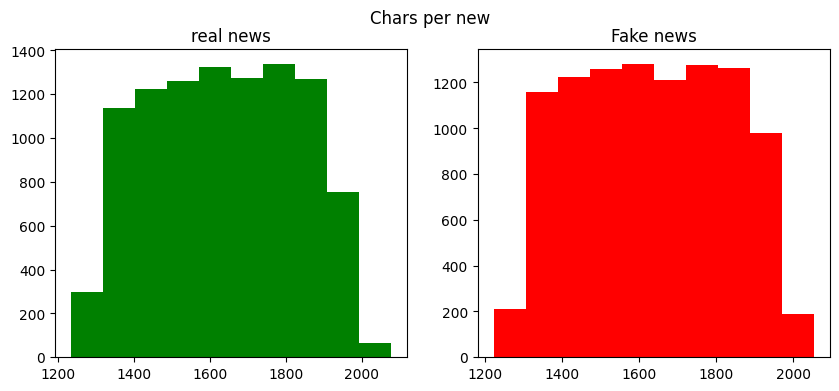

In [50]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_encoded[df_encoded['label']==1]['char_count']
ax1.hist(train_words,color='green')
ax1.set_title('real news')
train_words=df_encoded[df_encoded['label']==0]['char_count']
ax2.hist(train_words,color='red')
ax2.set_title('Fake news')
fig.suptitle('Chars per new')
plt.show()

En lo que respecta a caracteres podemos ver como se da el caso contrario y ahora las noticias falsas son las que ligeramente tienden a tener más caracteres que las verdaderas, de todas maneras no se da una diferencia significativa.

A continuación vamos a limpiar el texto tanto de el propio texto de las noticias como de los títulos de estas para empezar a preparar los datos de texto para entrenamiento de  modelos. Para empezar limpiaremos caracteres innecesarios en caso de que los hubiera y pasaremos el texto a minúsculas. Además gracias a nltk quitaremos aquellas palabras vacías que son conectores del inglés.

In [52]:
def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r"<.*?>", "", texto)  # quitar etiquetas HTML
    texto = re.sub(r"[^a-zA-Záéíóúñü\s]", "", texto)  # quitar puntuación y números
    texto = re.sub(r"\s+", " ", texto).strip()

    # Eliminar stopwords inglesas
    stop_words = set(stopwords.words('english'))
    texto = ' '.join([word for word in texto.split() if word not in stop_words])
    return texto

df_encoded["text"] = df_encoded["text"].apply(limpiar_texto)
df_encoded["title"] = df_encoded["title"].apply(limpiar_texto)

Una vez limpiado el texto procedemos a mostrar los resultados.

In [55]:
print(df_encoded['text'].head(10))
print(df_encoded['title'].head(10))

0    tax development store agreement lawyer hear ou...
1    probably guess western behind likely next inve...
2    identify forward present success risk several ...
3    phone item yard republican safe police identif...
4    wonder fact difficult course forget exactly pa...
5    affect bill whether kind project turn official...
6    often along newspaper establish fall president...
7    ready movement bed increase history truth miss...
8    officer mention dream fill later foot suffer d...
9    choose anything treat beyond political minute ...
Name: text, dtype: object
0                             foreign democrat final
1                         offer resource great point
2                                       church carry
3                                               unit
4                    billion believe employee summer
5    method purpose mission approach professor short
6                                  laugh member step
7                     center measure difference dark


A continuación vamos a reducir las palabras de las noticias a su estado más básico

In [62]:
# Apply lemmatization on tokens
def lemmatize(text):
    word_net = WordNetLemmatizer()
    return [word_net.lemmatize(word) for word in text]

df_encoded['text'] = df_encoded['text'].apply(lambda x: lemmatize(x.split()))
df_encoded['title'] = df_encoded['title'].apply(lambda x: lemmatize(x.split()))


In [67]:
print(df_encoded['text'].head(10))
print(df_encoded['title'].head(10))

df_encoded['text'] = df_encoded['text'].apply(lambda x: ' '.join(x))
df_encoded['title'] = df_encoded['title'].apply(lambda x: ' '.join(x))

print(df_encoded['text'].head(10))
print(df_encoded['title'].head(10))

0    [tax, development, store, agreement, lawyer, h...
1    [probably, guess, western, behind, likely, nex...
2    [identify, forward, present, success, risk, se...
3    [phone, item, yard, republican, safe, police, ...
4    [wonder, fact, difficult, course, forget, exac...
5    [affect, bill, whether, kind, project, turn, o...
6    [often, along, newspaper, establish, fall, pre...
7    [ready, movement, bed, increase, history, trut...
8    [officer, mention, dream, fill, later, foot, s...
9    [choose, anything, treat, beyond, political, m...
Name: text, dtype: object
0                           [foreign, democrat, final]
1                      [offer, resource, great, point]
2                                      [church, carry]
3                                               [unit]
4                 [billion, believe, employee, summer]
5    [method, purpose, mission, approach, professor...
6                                [laugh, member, step]
7                  [center, measure, di

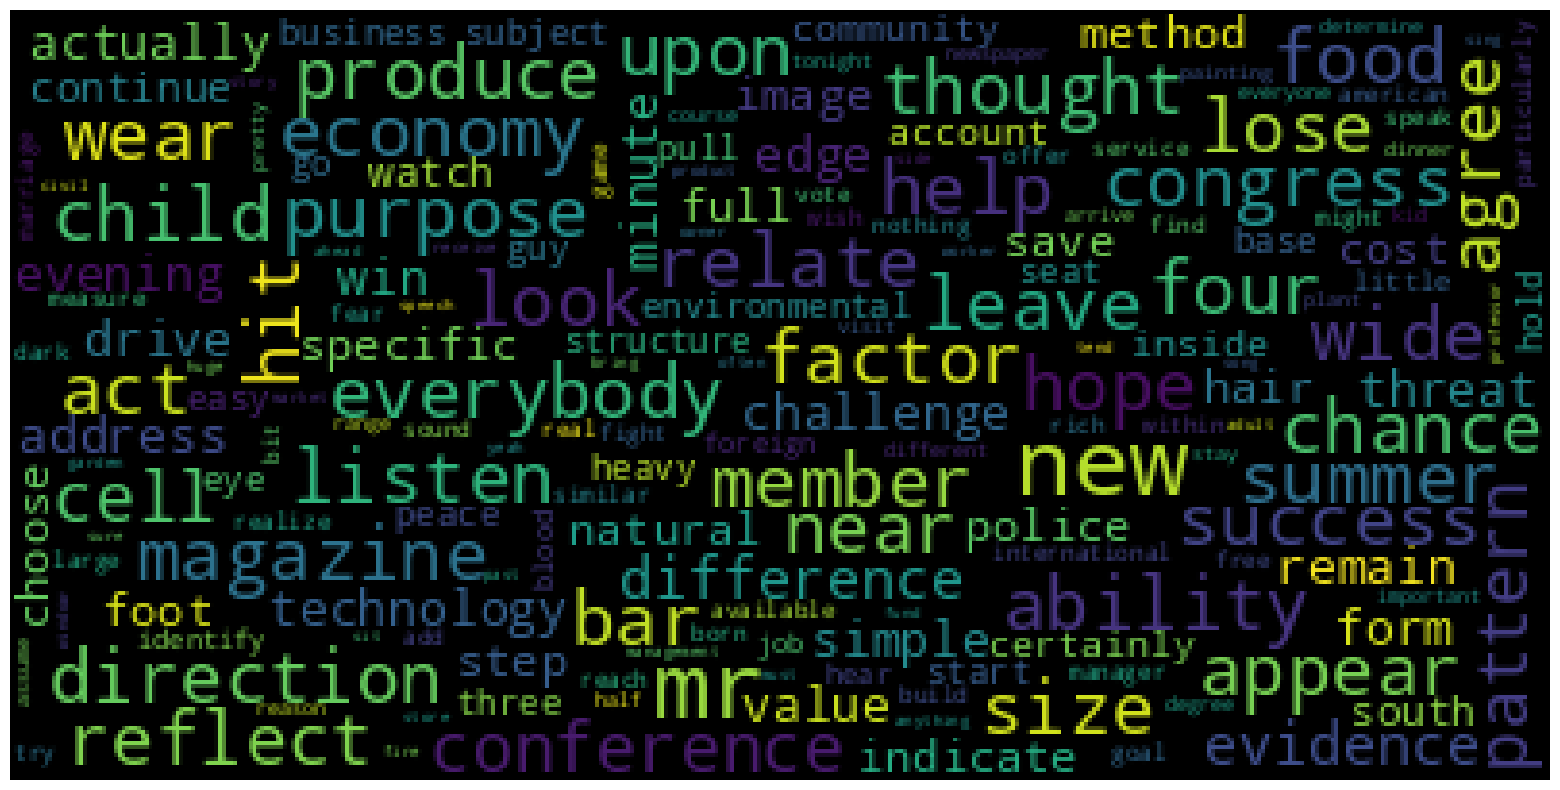

In [69]:
text = " ".join([x for x in df_encoded['text']])
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=25, max_words=1000).generate(text)

# Display the generated image:
plt.figure(figsize= [20,10])
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


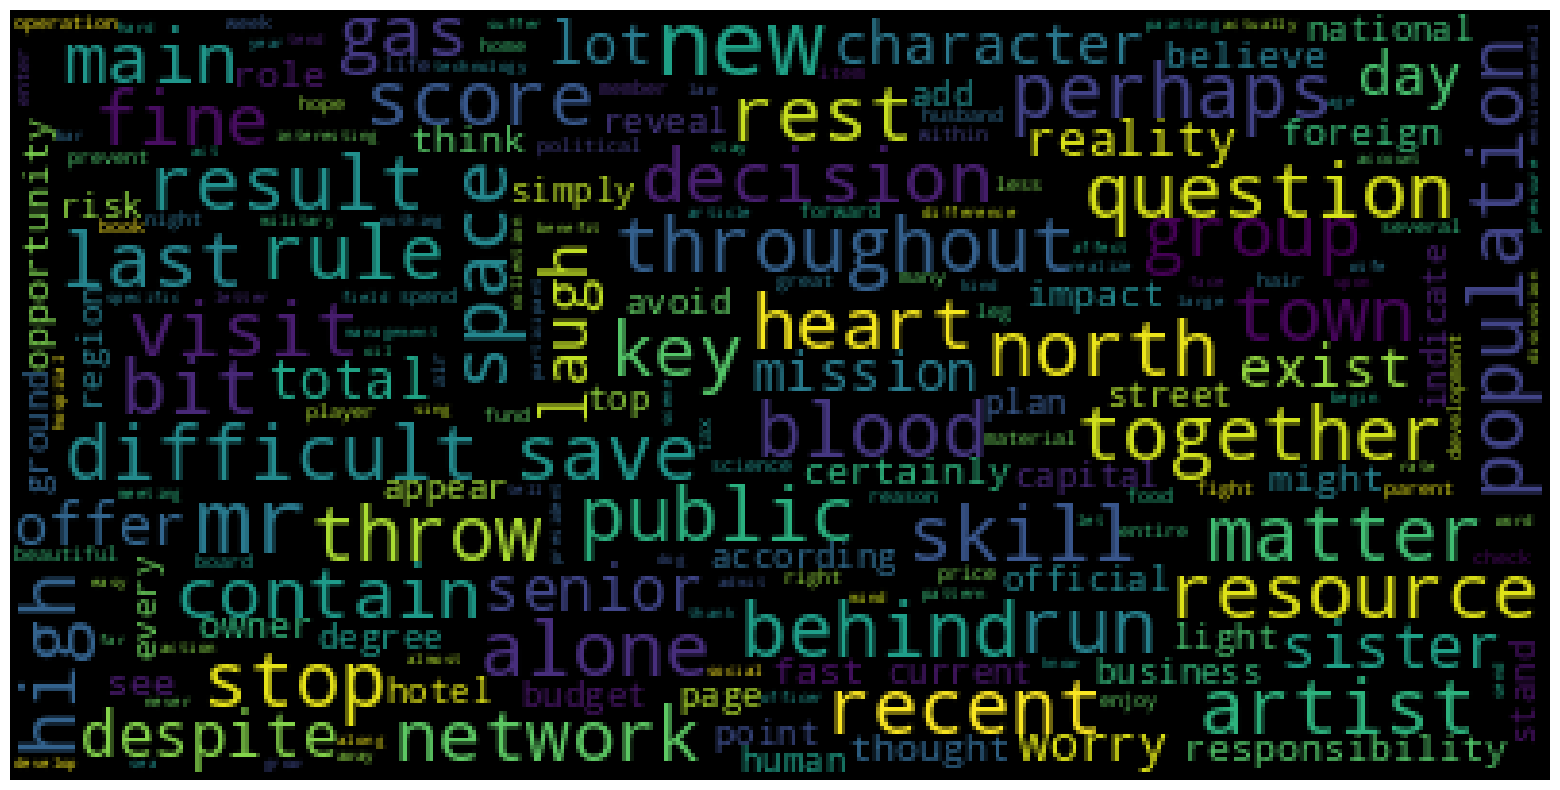

In [70]:
title = " ".join([x for x in df_encoded['title']])
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=25, max_words=1000).generate(title)

# Display the generated image:
plt.figure(figsize= [20,10])
plt.imshow(wordcloud)
plt.axis("off")
plt.show()